In [ ]:
import os

import random

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import cv2

import imghdr

import tensorflow as tf

from PIL import Image

import seaborn as sns



from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

from sklearn.utils.class_weight import compute_class_weight



from tensorflow.keras import layers, models, regularizers, optimizers

from tensorflow.keras.applications import VGG16, ResNet50V2

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger

from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.optimizers import Adam, Adamax

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

from keras.utils import plot_model


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Define your project name
project_name = 'Ovary cancer detection'

# List your models
model_names = [

    'VGG16_Transfer_Learning',
    'ResNet50_Transfer_Learning'
]

# Base directory inside Google Drive
base_dir = '/content/drive/MyDrive'

# Create the project directory inside MyDrive
project_dir = os.path.join(base_dir, project_name)
os.makedirs(project_dir, exist_ok=True)

# Create a subdirectory for each model
for each_model in model_names:
    model_dir = os.path.join(project_dir, each_model)
    os.makedirs(model_dir, exist_ok=True)

print(f'Project directory structure created at: {project_dir}')

# List the created directories to verify
!ls "$project_dir"


Project directory structure created at: /content/drive/MyDrive/Ovary cancer detection
ResNet50_Transfer_Learning  VGG16_Transfer_Learning


In [ ]:
import os

def use_existing_dataset(dataset_folder):
    """
    Uses the dataset directly from dataset_folder without copying anywhere.

    Parameters:
    - dataset_folder: The folder containing the dataset (train/test).
    """

    if os.path.exists(dataset_folder):
        print(f"Using dataset directly from: {dataset_folder}")
    else:
        print(f"Error: Dataset folder does not exist at {dataset_folder}")


if __name__ == "__main__":
    # Original dataset directory
    dataset_folder = "/content/drive/MyDrive/ovarian_cancer_dataset/OvarianCancer"

    # Use the dataset directly instead of copying
    use_existing_dataset(dataset_folder)


Using dataset directly from: /content/drive/MyDrive/ovarian_cancer_dataset/OvarianCancer


In [ ]:
import os
import imghdr
from PIL import Image
from tqdm import tqdm  # for progress bar

# List of allowed image extensions
image_exts = ['jpeg', 'jpg', 'png']

# Dataset path in Google Drive
data_dir = "/content/drive/MyDrive/ovarian_cancer_dataset"

# Count total files first
total_files = sum(len(files) for _, _, files in os.walk(data_dir))
print(f"Total files to check: {total_files}")

# Walk through all directories with progress bar
for root, dirs, files in os.walk(data_dir):
    for file in tqdm(files, desc=f"Checking in {root}", leave=False):
        file_path = os.path.join(root, file)
        try:
            # Check extension
            file_type = imghdr.what(file_path)
            if file_type not in image_exts:
                os.remove(file_path)
                continue

            # Verify file integrity using Pillow
            try:
                img = Image.open(file_path)
                img.verify()  # verify image is okay
            except:
                os.remove(file_path)

        except Exception:
            os.remove(file_path)

print("Dataset cleaning completed!")


Total files to check: 499


Dataset cleaning completed!


In [ ]:
import os

from PIL import Image, UnidentifiedImageError

import torchvision.transforms as T



def process_image(image_path, save_path, folder_name, augment_count=10, resize_dim=(224, 224)):

    try:

        # Open the image

        image = Image.open(image_path)



        # Resize the original image

        resized_image = image.resize(resize_dim)



        # Save the resized original image

        image_name, image_ext = os.path.splitext(os.path.basename(image_path))

        resized_image.save(os.path.join(save_path, f"{folder_name}_{image_name}_resized{image_ext}"))



        # Define augmentations

        transformations = T.Compose([

            T.RandomHorizontalFlip(),

            T.RandomVerticalFlip(),

            T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),

            T.RandomRotation(15),

            T.RandomAffine(degrees=0, translate=(0.05, 0.05)),

        ])



        # Generate and save augmented images

        for i in range(augment_count):

            augmented_image = transformations(resized_image)

            augmented_image.save(os.path.join(save_path, f"{folder_name}_{image_name}_augment_{i+1}{image_ext}"))



        # Remove the original image after processing

        os.remove(image_path)

        # print(f"Original image {image_path} removed successfully.")



    except (UnidentifiedImageError, OSError) as e:

        print(f"Skipping {image_path}: {e}")

        with open("skipped_files.log", "a") as log_file:

            log_file.write(f"{image_path}: {e}\n")



def augment_images_in_folder(root_folder, augment_count=10, resize_dim=(224, 224)):

    for subdir, _, files in os.walk(root_folder):

        folder_name = os.path.basename(subdir)

        for file in files:

            if file.lower().endswith(('.jpg', '.png', '.jpeg')):

                image_path = os.path.join(subdir, file)

                process_image(image_path, subdir, folder_name, augment_count, resize_dim)



if __name__ == "__main__":

    root_folder = "/content/drive/MyDrive/ovarian_cancer_dataset/OvarianCancer"  # Replace with your dataset folder path

    augment_count = 10  # Number of augmentations per image

    resize_dim = (224, 224)  # Resize dimensions (e.g., 224x224)

    augment_images_in_folder(root_folder, augment_count, resize_dim)




In [ ]:
import os

import shutil

import random



def create_train_test_split(root_folder, train_ratio=0.8, output_folder='data_split'):

    """

    Splits a dataset into train and test sets.



    Args:

        root_folder (str): Path to the root folder containing the dataset.

        train_ratio (float): The proportion of data to include in the training set.

        output_folder (str): The name of the folder where train and test folders will be created.

    """

    # Create output folder if it doesn't exist

    output_path = os.path.join(os.path.dirname(root_folder), output_folder)

    os.makedirs(output_path, exist_ok=True)



    # Create 'train' and 'test' directories within the output folder

    train_dir = os.path.join(output_path, 'train')

    test_dir = os.path.join(output_path, 'test')

    os.makedirs(train_dir, exist_ok=True)

    os.makedirs(test_dir, exist_ok=True)



    # Iterate over each subfolder (representing different types) in the root folder

    for subdir, dirs, files in os.walk(root_folder):

        if subdir == root_folder:  # Skip the root folder itself

            continue



        # Create subdirectories in train and test for each type of image

        type_name = os.path.basename(subdir)

        train_type_dir = os.path.join(train_dir, type_name)

        test_type_dir = os.path.join(test_dir, type_name)

        os.makedirs(train_type_dir, exist_ok=True)

        os.makedirs(test_type_dir, exist_ok=True)



        # List all image files in the subfolder

        image_files = [f for f in files if f.endswith(('.jpg', '.png', '.jpeg', '.JPG', '.PNG', '.JPEG'))]

        random.shuffle(image_files)



        # Split the data into train and test based on the given ratio

        split_index = int(len(image_files) * train_ratio)

        train_files = image_files[:split_index]

        test_files = image_files[split_index:]



        # Move the files to the corresponding directories

        for file in train_files:

            shutil.copy(os.path.join(subdir, file), os.path.join(train_type_dir, file))

        for file in test_files:

            shutil.copy(os.path.join(subdir, file), os.path.join(test_type_dir, file))



if __name__ == "__main__":

    root_folder = "/content/drive/MyDrive/ovarian_cancer_dataset/OvarianCancer"  # Update with the path to your dataset folder

    create_train_test_split(root_folder, train_ratio=0.8)

    print("Dataset split into train and test sets successfully.")

Dataset split into train and test sets successfully.


In [ ]:
# Define a function to count the number of files (assumed to be images for this context) for each subdirectory in a given directory.
# The function returns a DataFrame with these counts, indexed by a specified set name (e.g., 'train' or 'test').
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

# Paths to the training and testing directories.
train_dir = '/content/drive/MyDrive/ovarian_cancer_dataset/data_split/train'
test_dir = '/content/drive/MyDrive/ovarian_cancer_dataset/data_split/test'

# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)


       Non_Cancerous  Clear_Cell  Mucinous  Serous  Endometri
train            871         880       880     880        862
      Non_Cancerous  Clear_Cell  Mucinous  Serous  Endometri
test            218         220       220     220        216


<Axes: >

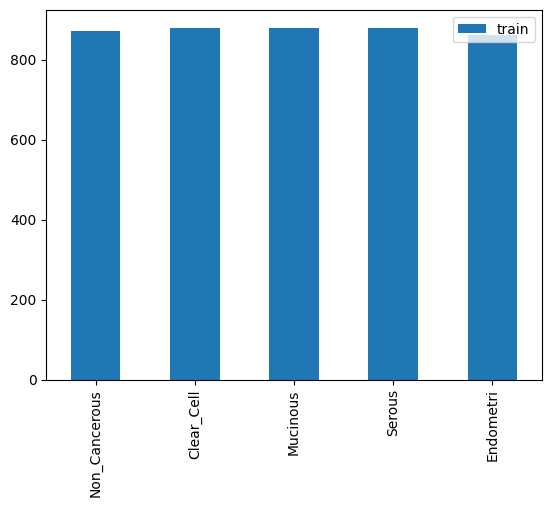

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

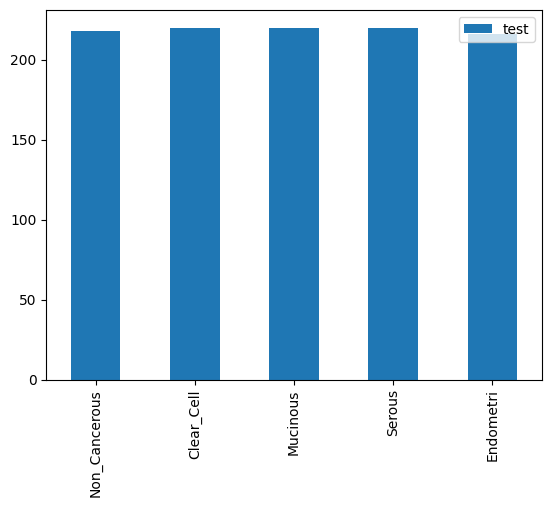

In [ ]:
  test_count.transpose().plot(kind='bar')

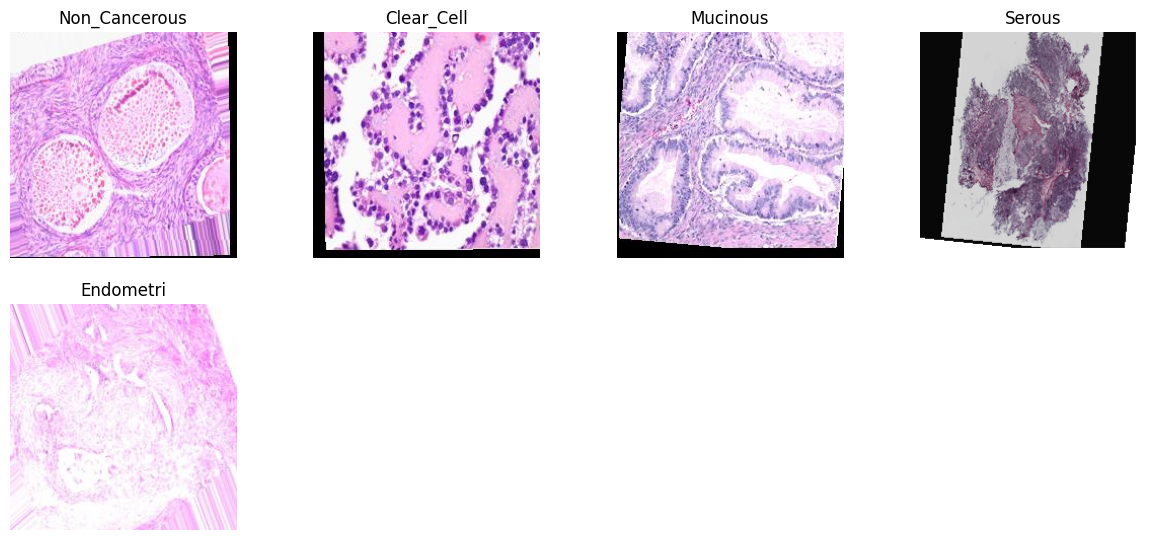

In [ ]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[42])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

In [ ]:
train_data_dir = '/content/drive/MyDrive/ovarian_cancer_dataset/data_split/train'
test_data_dir = '/content/drive/MyDrive/ovarian_cancer_dataset/data_split/test'


In [ ]:
# Set some parameters
img_width, img_height = 48, 48  # Size of images
batch_size = 64
epochs = 10
num_classes = 5  # Update this based on the number of your classes

In [ ]:
# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(rescale=1./255,
                                    validation_split=0.2)

# Automatically retrieve images and their classes for train and validation sets
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='grayscale',)
    # subset='validation')

Found 3499 images belonging to 5 classes.
Found 874 images belonging to 5 classes.
Found 1094 images belonging to 5 classes.


In [ ]:
# Accessing class labels for the training data
train_class_labels = train_generator.class_indices
print("Training class labels:", train_class_labels)

# Accessing class labels for the validation data
validation_class_labels = validation_generator.class_indices
print("Validation class labels:", validation_class_labels)

# Accessing class labels for the validation data
test_class_labels = test_generator.class_indices
print("Validation class labels:", test_class_labels)

Training class labels: {'Clear_Cell': 0, 'Endometri': 1, 'Mucinous': 2, 'Non_Cancerous': 3, 'Serous': 4}
Validation class labels: {'Clear_Cell': 0, 'Endometri': 1, 'Mucinous': 2, 'Non_Cancerous': 3, 'Serous': 4}
Validation class labels: {'Clear_Cell': 0, 'Endometri': 1, 'Mucinous': 2, 'Non_Cancerous': 3, 'Serous': 4}


In [ ]:
def plot_training_history(history):
    """
Plots the training and validation accuracy and loss.

Parameters:
- history: A Keras History object. Contains the logs from the training process.

Returns:
- None. Displays the matplotlib plots for training/validation accuracy and loss.
"""

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(20, 5))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    # Uncomment the line below if you want to display the plot
    plt.show()

vgg and resnet


In [ ]:
# Define paths to the train and validation directories
train_data_dir = '/content/drive/MyDrive/ovarian_cancer_dataset/data_split/train'
test_data_dir = '/content/drive/MyDrive/ovarian_cancer_dataset/data_split/test'

# Set some parameters
img_width, img_height = 224, 224  # Size of images
batch_size = 64
epochs = 10
num_classes = 5  # Update this based on the number of your classes

# Rescale the pixel values (0-255) to the [0, 1] interval
data_generator = ImageDataGenerator(
    rescale=1 / 255.,
    rotation_range=10,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

test_preprocessor = ImageDataGenerator(
    rescale=1 / 255.,
)

# Train data
train_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',
    subset='training',
    shuffle=True
)

# Test data
test_generator = test_preprocessor.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb'
)

# Validation data (from train folder with subset)
validation_generator = data_generator.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    color_mode='rgb',  # changed to rgb for consistency
    subset='validation'
)


Found 3499 images belonging to 5 classes.
Found 1094 images belonging to 5 classes.
Found 874 images belonging to 5 classes.


In [ ]:
# Extract class labels for all instances in the training dataset

classes = np.array(train_generator.classes)



# Calculate class weights to handle imbalances in the training data

# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies

class_weights = compute_class_weight(

    class_weight='balanced',  # Strategy to balance classes

    classes=np.unique(classes),  # Unique class labels

    y=classes  # Class labels for each instance in the training dataset

)



# Create a dictionary mapping class indices to their calculated weights

class_weights_dict = dict(enumerate(class_weights))



# Output the class weights dictionary

print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: np.float64(0.9940340909090909), 1: np.float64(1.0142028985507245), 2: np.float64(0.9940340909090909), 3: np.float64(1.0040172166427546), 4: np.float64(0.9940340909090909)}


In [ ]:
train_generator.class_indices

{'Clear_Cell': 0,
 'Endometri': 1,
 'Mucinous': 2,
 'Non_Cancerous': 3,
 'Serous': 4}

In [ ]:
classes = 5



# Clear the previous TensorFlow sessionx

tf.keras.backend.clear_session()



# Load the VGG16 base model, excluding its top (fully connected) layers

vgg = VGG16(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Make the specified layers non-trainable

for layer in vgg.layers[:-3]:

    layer.trainable = False



vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 4,719,616 (18.00 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [ ]:
classes

5

In [ ]:
# Flattening the layer and adding custom Dense layers

x = Flatten()(vgg.output)



# Adding a fully connected layer with ReLU activation and He normal initializer

x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)

x = Dropout(0.5)(x)  # Adding dropout for regularization



x = Dense(512, activation='relu', kernel_initializer='he_normal')(x)

x = Dropout(0.5)(x)  # Adding dropout for regularization



# Adding the output layer with softmax activation

# Note: Adjust the number of units to match the number of classes you have

output = Dense(5, activation='softmax', kernel_initializer='he_normal')(x)



# Creating the model

model = Model(inputs=vgg.input, outputs=output)



# Compile the model

model.compile(loss='categorical_crossentropy',

              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),

              metrics=['accuracy'])



# Model summary to see all layers

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         2,56

 Total params: 40,933,189 (156.15 MB)

 Trainable params: 30,938,117 (118.02 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [ ]:


# Path for saving model checkpoints
cnn_path = '/content/drive/MyDrive/ovarian_cancer_dataset/VGG16_Transfer_Learning'
os.makedirs(cnn_path, exist_ok=True)  # Create folder if it doesn't exist

# Checkpoint file name
name = 'VGG16_Transfer_Learning.keras'
chk_path = os.path.join(cnn_path, name)

# Callback for saving best model
checkpoint = ModelCheckpoint(
    filepath=chk_path,
    save_best_only=True,
    verbose=1,
    mode='min',
    monitor='val_loss'
)

# Early stopping callback
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
)

# Reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=6,
    verbose=1,
    min_delta=0.0001
)

# CSV logger to track training progress
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

# Aggregating all callbacks into a list

callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]  # Adjusted as per your use-case



train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1

# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1

test_steps_epoch = test_generator.samples // test_generator.batch_size + 1



In [ ]:
history = model.fit(

    train_generator,

    steps_per_epoch=100,  # Small number for debugging

    epochs=50,

    validation_data=test_generator,

    validation_steps=1,

    class_weight=class_weights_dict,

    callbacks=callbacks

)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
 55/100 ━━━━━━━━━━━━━━━━━━━━ 1:09 2s/step - accuracy: 0.3522 - loss: 1.6871

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.69988, saving model to /content/drive/MyDrive/ovarian_cancer_dataset/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.4076 - loss: 1.5278 - val_accuracy: 0.7500 - val_loss: 0.6999 - learning_rate: 1.0000e-04
Epoch 2/50
 55/100 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.7104 - loss: 0.7990
Epoch 2: val_loss improved from 0.69988 to 0.36813, saving model to /content/drive/MyDrive/ovarian_cancer_dataset/VGG16_Transfer_Learning/VGG16_Transfer_Learning.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 85s 670ms/step - accuracy: 0.7301 - loss: 0.7456 - val_accuracy: 0.8438 - val_loss: 0.3681 - learning_rate: 1.0000e-04
Epoch 3/50
 55/100 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.8144 - loss: 0.5279 
Epoch 3: val_loss did not improve from 0.36813
100/100 ━━━━━━━━━━━━━━━━━━━━ 80s 732ms/step - accuracy: 0.8259 - loss: 0.5006 - val_accuracy: 0.8281 - val_loss: 0.5715 - learning_rate: 1.0000e-04
Epoch

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)

test_loss, test_accu = model.evaluate(test_generator)

print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

55/55 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.9920 - loss: 0.0268
18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 545ms/step - accuracy: 0.9293 - loss: 0.3374
final train accuracy = 99.26 , validation accuracy = 93.42


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 380ms/step


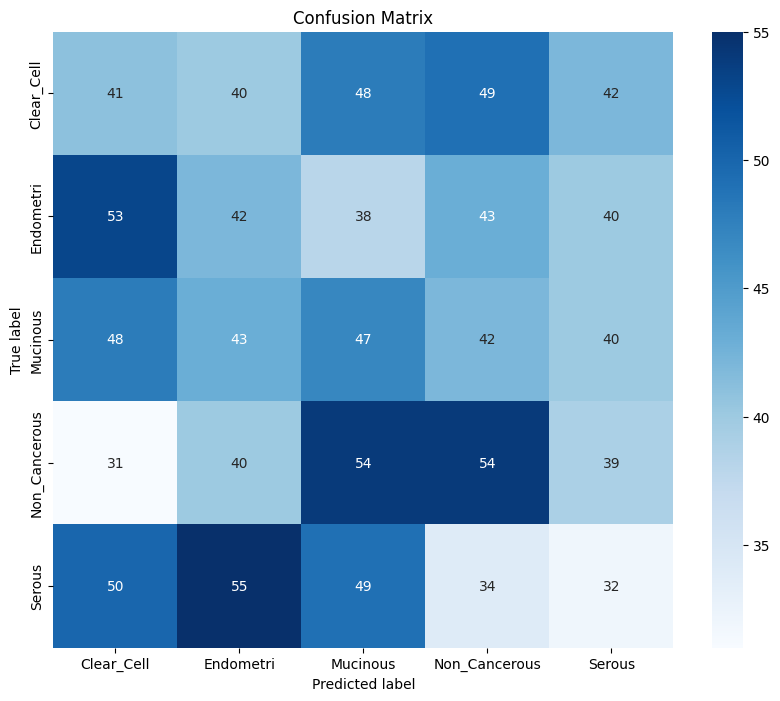

In [ ]:
# Assuming your true_classes and predicted_classes are already defined

true_classes = test_generator.classes

predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1) # Convert steps to integer

class_labels = list(test_generator.class_indices.keys())



# Generate the confusion matrix

cm = confusion_matrix(true_classes, predicted_classes)



# Plotting with seaborn

plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')

plt.ylabel('True label')

plt.xlabel('Predicted label')

plt.show()

In [ ]:
# Printing the classification report

report = classification_report(true_classes,

                               predicted_classes,

                               target_names=class_labels,

                               zero_division=0)

print("Classification Report:\n", report)

Classification Report:
                precision    recall  f1-score   support

   Clear_Cell       0.18      0.19      0.19       220
    Endometri       0.19      0.19      0.19       216
     Mucinous       0.20      0.21      0.21       220
Non_Cancerous       0.24      0.25      0.25       218
       Serous       0.17      0.15      0.15       220

     accuracy                           0.20      1094
    macro avg       0.20      0.20      0.20      1094
 weighted avg       0.20      0.20      0.20      1094



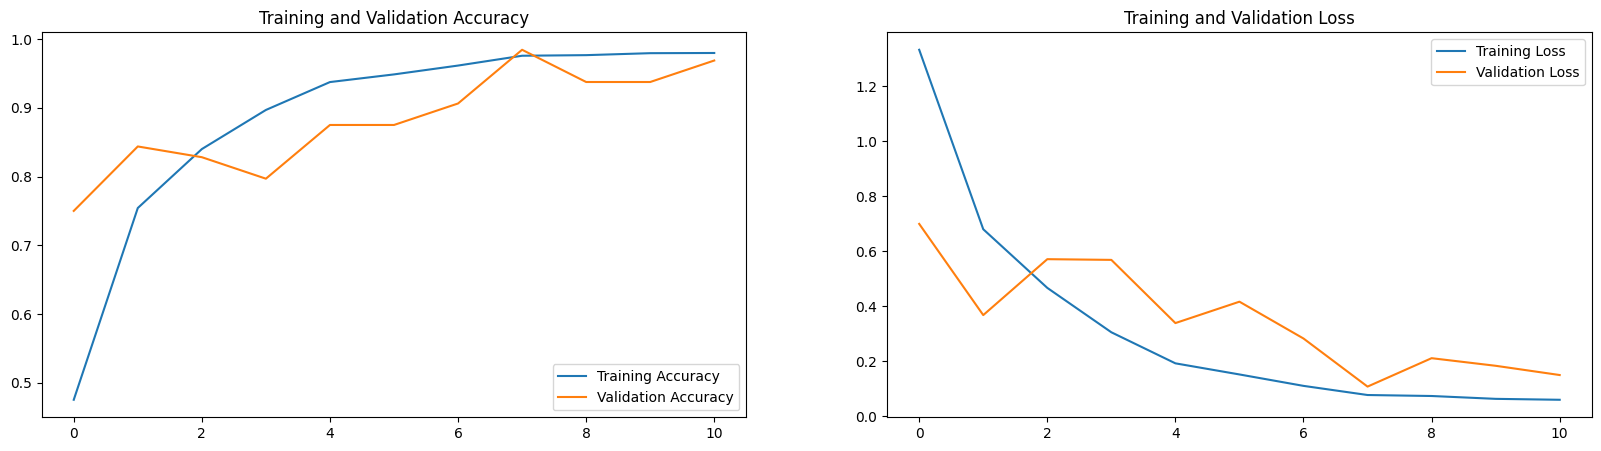

In [ ]:
plot_training_history(history)

In [ ]:
 model.save("Test_model.keras")

In [ ]:
# Directory paths for training and testing data

train_dir = '/content/drive/MyDrive/ovarian_cancer_dataset/data_split/train'
test_dir =  '/content/drive/MyDrive/ovarian_cancer_dataset/data_split/test'





# Batch size for data generators

batch_size = 64



# Data augmentation configuration for training data

train_datagen = ImageDataGenerator(

                                  rescale=1 / 255.,  # Rescale pixel values to [0,1]

                                  rotation_range=10,  # Random rotation within range [-10,10] degrees

                                  zoom_range=0.2,  # Random zoom between [0.8, 1.2]

                                  width_shift_range=0.1,  # Random horizontal shift within range [-0.1, 0.1]

                                  height_shift_range=0.1,  # Random vertical shift within range [-0.1, 0.1]

                                  horizontal_flip=True,  # Random horizontal flip

                                  fill_mode='nearest'  # Fill mode for handling newly created pixels

                                 )



# Configuration for testing data (only rescaling)

test_datagen = ImageDataGenerator(

                                  rescale=1 / 255.  # Rescale pixel values to [0,1]

                                 )



# Data generators for training and testing data

train_generator = train_datagen.flow_from_directory(

                                                    train_dir,  # Directory containing training data

                                                    class_mode="categorical",  # Classification mode for categorical labels

                                                    target_size=(224, 224),  # Resize input images to (224,224)

                                                    color_mode='rgb',  # Color mode for images (RGB)

                                                    shuffle=True,  # Shuffle training data

                                                    batch_size=batch_size,  # Batch size for training

                                                    subset='training'  # Subset of data (training)

                                                   )



test_generator = test_datagen.flow_from_directory(

                                                  test_dir,  # Directory containing testing data

                                                  class_mode="categorical",  # Classification mode for categorical labels

                                                  target_size=(224, 224),  # Resize input images to (224,224)

                                                  color_mode="rgb",  # Color mode for images (RGB)

                                                  shuffle=False,  # Do not shuffle testing data

                                                  batch_size=batch_size  # Batch size for testing

                                                 )



Found 4373 images belonging to 5 classes.
Found 1094 images belonging to 5 classes.


In [ ]:
# Extract class labels for all instances in the training dataset

classes = np.array(train_generator.classes)



# Calculate class weights to handle imbalances in the training data

# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies

class_weights = compute_class_weight(

    class_weight='balanced',  # Strategy to balance classes

    classes=np.unique(classes),  # Unique class labels

    y=classes  # Class labels for each instance in the training dataset

)



# Create a dictionary mapping class indices to their calculated weights

class_weights_dict = dict(enumerate(class_weights))



# Output the class weights dictionary

print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: np.float64(0.9938636363636364), 1: np.float64(1.01461716937355), 2: np.float64(0.9938636363636364), 3: np.float64(1.0041331802525832), 4: np.float64(0.9938636363636364)}


In [ ]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

In [ ]:
# Freezing all layers except last 50

ResNet50V2.trainable = True
for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [ ]:
def Create_ResNet50V2_Model():



    model = Sequential([

                      ResNet50V2,

                      Dropout(0.25),

                      BatchNormalization(),

                      Flatten(),

                      Dense(64, activation='relu'),

                      BatchNormalization(),

                      Dropout(0.5),

                      Dense(5,activation='softmax')

                    ])

    return model

In [ ]:
model = Create_ResNet50V2_Model()
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 2048)     │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │     6,422,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,996,165 (114.43 MB)

 Trainable params: 22,779,397 (86.90 MB)

 Non-trainable params: 7,216,768 (27.53 MB)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# File path for the model checkpoint

cnn_path = '/content/drive/MyDrive/ovarian_cancer_dataset/ResNet50_Transfer_Learning1'
# Create the directory if it doesn't exist
os.makedirs(cnn_path, exist_ok=True)

name = 'ResNet50_Transfer_Learning1.keras'
chk_path = os.path.join(cnn_path, name)
# Callback to save the model checkpoint

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                            verbose=1,
                             mode='min',
                             monitor='val_loss')


# Callback for early stopping

earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 7,
                          restore_best_weights = True,
                          verbose=1)

# Callback to reduce learning rate

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=2,
#                             min_lr=0.00005,
                              verbose=1)



# Callback to log training data to a CSV file

csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))



# Aggregating all callbacks into a list

callbacks = [checkpoint, earlystop, csv_logger]  # Adjusted as per your use-case



train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1

# validation_steps_epoch = validation_generator.samples // validation_generator.batch_size + 1

test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
history = model.fit(

    train_generator,

    steps_per_epoch=100,  # Small number for debugging

    epochs=50,

    validation_data=test_generator,

    validation_steps=1,

    class_weight=class_weights_dict,

    callbacks=callbacks

)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
 69/100 ━━━━━━━━━━━━━━━━━━━━ 38s 1s/step - accuracy: 0.6137 - loss: 1.1380

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_loss improved from inf to 0.02240, saving model to /content/drive/MyDrive/ovarian_cancer_dataset/ResNet50_Transfer_Learning1/ResNet50_Transfer_Learning1.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 119s 929ms/step - accuracy: 0.6605 - loss: 1.0004 - val_accuracy: 0.9844 - val_loss: 0.0224
Epoch 2/50
 69/100 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9308 - loss: 0.2236
Epoch 2: val_loss did not improve from 0.02240
100/100 ━━━━━━━━━━━━━━━━━━━━ 137s 993ms/step - accuracy: 0.9328 - loss: 0.2184 - val_accuracy: 0.7031 - val_loss: 2.5264
Epoch 3/50
 69/100 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9522 - loss: 0.1459
Epoch 3: val_loss did not improve from 0.02240
100/100 ━━━━━━━━━━━━━━━━━━━━ 120s 777ms/step - accuracy: 0.9533 - loss: 0.1464 - val_accuracy: 0.8750 - val_loss: 0.4496
Epoch 4/50
 69/100 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9580 - loss: 0.1502
Epoch 4: val_loss improved from 0.02240 to 0.01723, saving model to /content/drive/MyDrive/ovarian_cancer_datase

In [ ]:
train_loss, train_accu = model.evaluate(train_generator)

test_loss, test_accu = model.evaluate(test_generator)

print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))


69/69 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9840 - loss: 0.0454
18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 444ms/step - accuracy: 0.9932 - loss: 0.0267
final train accuracy = 98.47 , validation accuracy = 99.09


In [ ]:
final_model_path = '/content/drive/MyDrive/ovarian_cancer_dataset/ResNet50_Final_Model1.keras'
model.save(final_model_path)

18/18 ━━━━━━━━━━━━━━━━━━━━ 9s 478ms/step


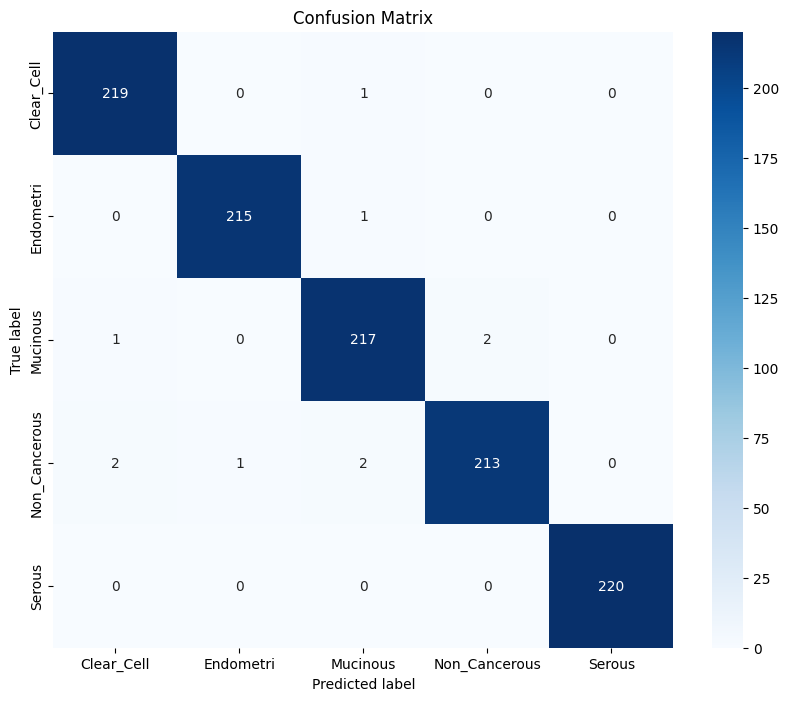

In [ ]:
# Assuming your true_classes and predicted_classes are already defined

true_classes = test_generator.classes

predicted_classes = np.argmax(model.predict(test_generator, steps=int(np.ceil(test_generator.samples/test_generator.batch_size))), axis=1) # Convert steps to integer

class_labels = list(test_generator.class_indices.keys())



# Generate the confusion matrix

cm = confusion_matrix(true_classes, predicted_classes)



# Plotting with seaborn

plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')

plt.ylabel('True label')

plt.xlabel('Predicted label')

plt.show()

In [ ]:
# Printing the classification report

report = classification_report(true_classes,

                               predicted_classes,

                               target_names=class_labels,

                               zero_division=0)

print("Classification Report:\n", report)

Classification Report:
                precision    recall  f1-score   support

   Clear_Cell       0.99      1.00      0.99       220
    Endometri       1.00      1.00      1.00       216
     Mucinous       0.98      0.99      0.98       220
Non_Cancerous       0.99      0.98      0.98       218
       Serous       1.00      1.00      1.00       220

     accuracy                           0.99      1094
    macro avg       0.99      0.99      0.99      1094
 weighted avg       0.99      0.99      0.99      1094



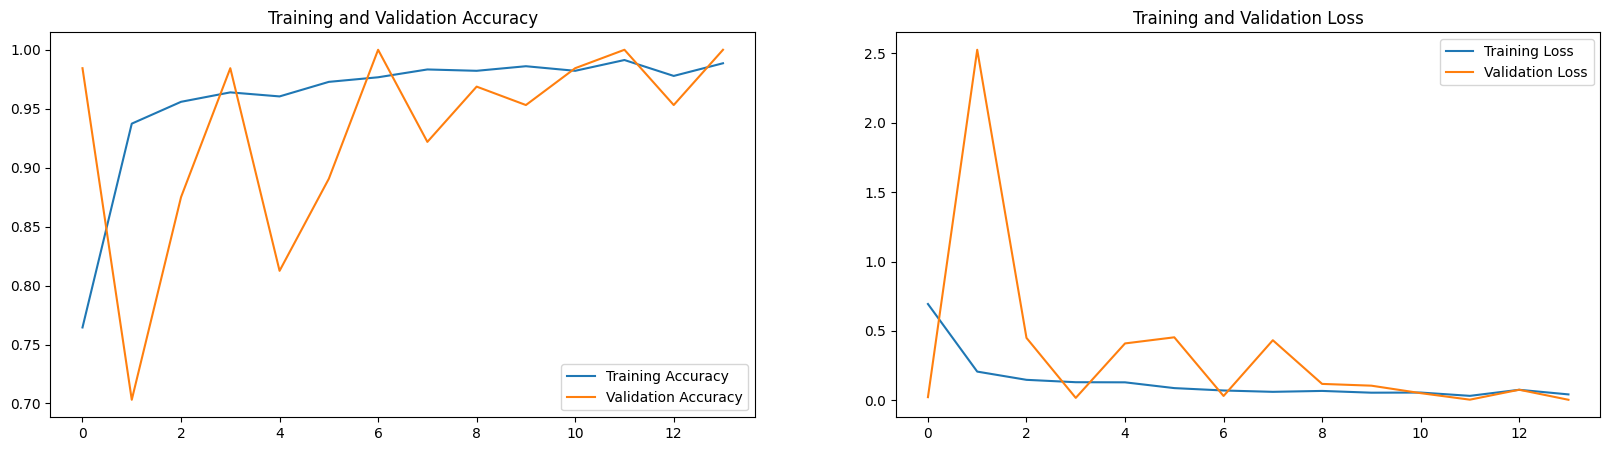

In [ ]:
plot_training_history(history)

In [ ]:
from tensorflow.keras.models import load_model



# Path to your saved model

model_path = '/content/drive/MyDrive/ovarian_cancer_dataset/ResNet50_Final_Model1.keras'



# Load the trained model

model = load_model(model_path)

print("Model loaded successfully!")


Model loaded successfully!


We can also visualize the confusion matrix and print the classification report to get a better understanding of the model's performance on each class.

In [ ]:
    import numpy as np

    from tensorflow.keras.preprocessing.image import load_img, img_to_array



    # Path to your image

    image_path = '/content/drive/MyDrive/ovarian_cancer_dataset/OvarianCancer/Non_Cancerous/32.jpg'



    # Load and preprocess the image

    img_width, img_height = 224, 224  # Image dimensions

    image = load_img(image_path, target_size=(img_width, img_height))  # Load and resize

    image_array = img_to_array(image)  # Convert to NumPy array

    image_array = image_array / 255.0  # Rescale pixel values

    image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension


Now that the ResNet50V2 model has been trained, let's evaluate its performance using the test dataset.

In [ ]:
# Get predictions

predictions = model.predict(image_array)



# Print predictions

print("Predicted probabilities:", predictions)



# Get the class with the highest probability

predicted_class = np.argmax(predictions, axis=1)

print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted probabilities: [[1.9955956e-05 5.3021681e-06 8.3291206e-06 9.9994326e-01 2.3177170e-05]]
Predicted class: [3]


In [ ]:


# Path to your Google Drive directory
save_dir = "/content/drive/MyDrive/ovarian_cancer_dataset/OvarianCancer"
os.makedirs(save_dir, exist_ok=True)  # Make sure the folder exists

# Full path for the saved model
model_path = os.path.join(save_dir, "resnet1.keras")

# Save the model
model.save(model_path)

print(f"✅ Model saved successfully at: {model_path}")


✅ Model saved successfully at: /content/drive/MyDrive/ovarian_cancer_dataset/OvarianCancer/resnet1.keras
